## Importar librerias

In [87]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

## Cargar imagenes

In [57]:
images_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    directory='Data/train/', 
    target_size=(256, 256),
    batch_size=3000,
    seed=0
)

X = images_gen[0][0]
y = images_gen[0][1]

Found 3000 images belonging to 2 classes.


## Visualizar datos

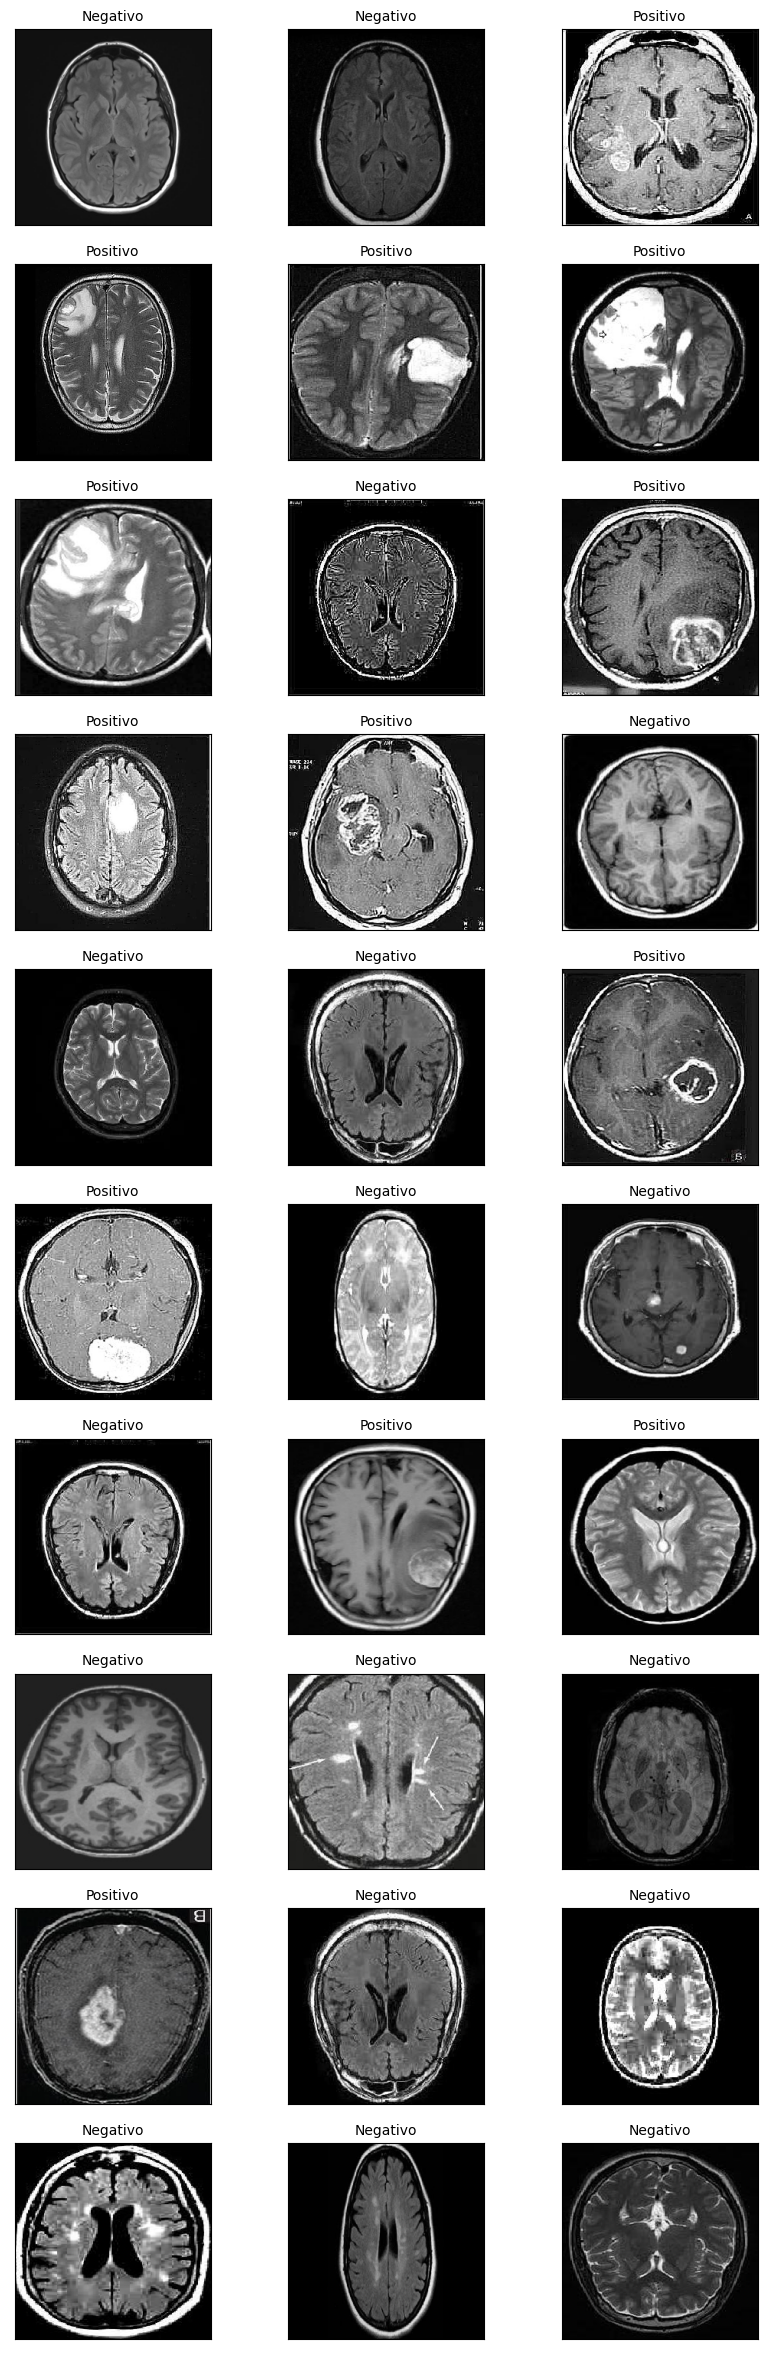

In [58]:
fig, ax = plt.subplots(10,3, figsize=(10,30))
ax = ax.flatten()
for i in range(30):
    ax[i].imshow(X[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(
        'Negativo' if y[i,0] == 1 else 'Positivo', 
        fontsize=10
    )
plt.show()

## Particionar dataset

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 450, random_state=0)

In [60]:
print('Train:\t', X_train.shape)
print('Test:\t', X_test.shape)

Train:	 (2550, 256, 256, 3)
Test:	 (450, 256, 256, 3)


## Crear modelo CNN Classifier 

In [61]:
def CNN_classifier(
    input_shape=(100,100,3), 
    output_shape=2, 
    n_filters_conv=(16,), 
    n_units_dense = (100,), 
    activation='relu',
    name='model'
):
    clear_session()
    cnn = Sequential(name=name)
    cnn.add(Input(shape=input_shape))
    for i, n_filters in enumerate(n_filters_conv, start=1):
        cnn.add(Conv2D(
            filters=n_filters, 
            kernel_size=(3,3), 
            activation=activation, 
            padding='same',
            name=f'{name}_conv{i}'
        ))
        cnn.add(MaxPool2D(pool_size=(2,2), name=f'{name}_pool{i}'))
    cnn.add(Flatten(name=f'{name}_flatten'))
    for i, n_units in enumerate(n_units_dense, start=1):
        cnn.add(Dense(units=n_units, activation=activation, name=f'{name}_dense{i}'))
    cnn.add(Dense(units=output_shape, activation='softmax',name=f'{name}_predictions'))
    cnn.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='Accuracy')
    return cnn

## Creamos 5 instancias del modelo

In [62]:
models = []
for i in range(5):
    model = CNN_classifier(
        input_shape=(256,256,3), 
        output_shape=2, 
        n_filters_conv=(16,32), 
        n_units_dense = (64,), 
        activation='relu',
        name=f'model{i+1}'
    )
    models.append(model)

In [63]:
models[0].summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model1_conv1 (Conv2D)       (None, 256, 256, 16)      448       
                                                                 
 model1_pool1 (MaxPooling2D)  (None, 128, 128, 16)     0         
                                                                 
 model1_conv2 (Conv2D)       (None, 128, 128, 32)      4640      
                                                                 
 model1_pool2 (MaxPooling2D)  (None, 64, 64, 32)       0         
                                                                 
 model1_flatten (Flatten)    (None, 131072)            0         
                                                                 
 model1_dense1 (Dense)       (None, 64)                8388672   
                                                                 
 model1_predictions (Dense)  (None, 2)                 130  

## Entrenar modelos

Para entrenar los modelos se utilizó el conjunto de datos ` X_train ` 
siguiendo el esquema que se muestra en la imagen. Se dividieron los 
datos en 5 muestras aleatorias con 510 ejemplos cada una. Cada muestra 
se utilizó como datos de validación de uno de los modelos y las otras 
4 muestras restantes como datos de entrenamiento. 

<img src="images/train.JPG" width=400>

In [64]:
history_train = []

for i, model in enumerate(models):
    
    [X_train_1, X_val, X_train_2] = np.split(X_train, [i*510, i*510+510], axis=0)
    [y_train_1, y_val, y_train_2] = np.split(y_train, [i*510, i*510+510], axis=0)
    X_train_new = np.concatenate((X_train_1,X_train_2), axis=0)
    y_train_new = np.concatenate((y_train_1,y_train_2), axis=0)
    
    checkpoint = ModelCheckpoint(
        f"Models/model_cnn_{i+1}.h5",
        monitor='val_accuracy',
        mode='max'
    )
    
    print(f"\n\nModel {i+1}:\n")
    history = model.fit(
        X_train_new, 
        y_train_new, 
        validation_data=(X_val,y_val), 
        batch_size=64, 
        epochs=16, 
        callbacks=[checkpoint]
    )
    
    history_train.append(history)
    



Model 1:

Epoch 1/16
32/32 [==============================] - 73s 2s/step - loss: 1.1526 - Accuracy: 0.6667 - val_loss: 0.4860 - val_Accuracy: 0.7529
Epoch 2/16
32/32 [==============================] - 68s 2s/step - loss: 0.3969 - Accuracy: 0.8157 - val_loss: 0.3327 - val_Accuracy: 0.8412
Epoch 3/16
32/32 [==============================] - 89s 3s/step - loss: 0.1921 - Accuracy: 0.9363 - val_loss: 0.2001 - val_Accuracy: 0.9216
Epoch 4/16
32/32 [==============================] - 73s 2s/step - loss: 0.0793 - Accuracy: 0.9779 - val_loss: 0.1037 - val_Accuracy: 0.9647
Epoch 5/16
32/32 [==============================] - 75s 2s/step - loss: 0.0297 - Accuracy: 0.9941 - val_loss: 0.0796 - val_Accuracy: 0.9725
Epoch 6/16
32/32 [==============================] - 75s 2s/step - loss: 0.0135 - Accuracy: 0.9995 - val_loss: 0.0717 - val_Accuracy: 0.9765
Epoch 7/16
32/32 [==============================] - 71s 2s/step - loss: 0.0044 - Accuracy: 1.0000 - val_loss: 0.0789 - val_Accuracy: 0.9725
Epoch 8/

32/32 [==============================] - 79s 2s/step - loss: 7.5600e-04 - Accuracy: 1.0000 - val_loss: 0.1465 - val_Accuracy: 0.9686
Epoch 11/16
32/32 [==============================] - 73s 2s/step - loss: 5.1613e-04 - Accuracy: 1.0000 - val_loss: 0.1351 - val_Accuracy: 0.9745
Epoch 12/16
32/32 [==============================] - 80s 3s/step - loss: 4.1912e-04 - Accuracy: 1.0000 - val_loss: 0.1473 - val_Accuracy: 0.9725
Epoch 13/16
32/32 [==============================] - 76s 2s/step - loss: 3.2050e-04 - Accuracy: 1.0000 - val_loss: 0.1525 - val_Accuracy: 0.9725
Epoch 14/16
32/32 [==============================] - 73s 2s/step - loss: 2.6650e-04 - Accuracy: 1.0000 - val_loss: 0.1459 - val_Accuracy: 0.9745
Epoch 15/16
32/32 [==============================] - 70s 2s/step - loss: 2.3408e-04 - Accuracy: 1.0000 - val_loss: 0.1553 - val_Accuracy: 0.9725
Epoch 16/16
32/32 [==============================] - 78s 2s/step - loss: 1.9637e-04 - Accuracy: 1.0000 - val_loss: 0.1587 - val_Accuracy: 0.97

## Graficar métricas

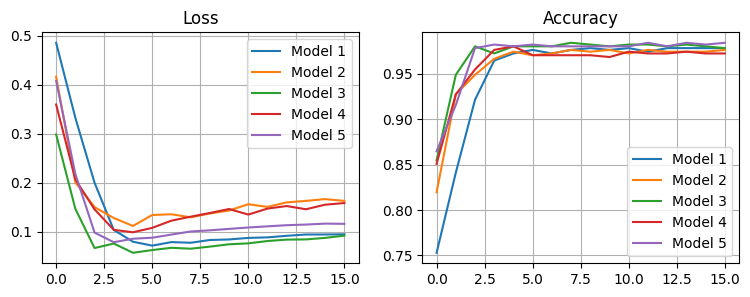

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))
for i in range(5):
    ax[0].plot(history_train[i].epoch, history_train[i].history['val_loss'], label=f"Model {i+1}")
    ax[1].plot(history_train[i].epoch, history_train[i].history['val_Accuracy'], label=f"Model {i+1}")
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.show()

## Cargar modelos desde archivo

In [66]:
models = []
for i in range(1,6):
    model = load_model(f'Models/model_cnn_{i}.h5')
    models.append(model)

## Concatenar modelos

In [67]:
input_ = Input(shape=(256,256,3))
x = []
for i, model in enumerate(models):
    x.append(input_)
    for j in range(7):
        x[i] = model.get_layer(index=j)(x[i])     
output = Concatenate()(x)

model = Model(input_, output)

In [68]:
X_train_new = model.predict(X_train)

80/80 [==============================] - 217s 3s/step


## Entrenar meta modelo

In [69]:
meta_model = Sequential([
    Input(shape=(10,)),
    Dense(units=2,activation='softmax', name='softmax')
])
meta_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 softmax (Dense)             (None, 2)                 22        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [70]:
meta_model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='Accuracy')
checkpoint = ModelCheckpoint(
    "Models/meta_model.h5",
    monitor='val_accuracy',
    mode='max'
)

history = meta_model.fit(
    X_train_new, 
    y_train, 
    validation_split=0.2, 
    batch_size=64, 
    epochs=16, 
    callbacks=[checkpoint]
)

Epoch 1/16
32/32 [==============================] - 1s 17ms/step - loss: 1.1264 - Accuracy: 0.3025 - val_loss: 1.0455 - val_Accuracy: 0.4745
Epoch 2/16
32/32 [==============================] - 0s 5ms/step - loss: 0.9318 - Accuracy: 0.5074 - val_loss: 0.8603 - val_Accuracy: 0.4745
Epoch 3/16
32/32 [==============================] - 0s 5ms/step - loss: 0.7660 - Accuracy: 0.5093 - val_loss: 0.7047 - val_Accuracy: 0.4745
Epoch 4/16
32/32 [==============================] - 0s 5ms/step - loss: 0.6288 - Accuracy: 0.5108 - val_loss: 0.5775 - val_Accuracy: 0.4745
Epoch 5/16
32/32 [==============================] - 0s 4ms/step - loss: 0.5174 - Accuracy: 0.7392 - val_loss: 0.4753 - val_Accuracy: 1.0000
Epoch 6/16
32/32 [==============================] - 0s 4ms/step - loss: 0.4286 - Accuracy: 0.9912 - val_loss: 0.3947 - val_Accuracy: 1.0000
Epoch 7/16
32/32 [==============================] - 0s 4ms/step - loss: 0.3583 - Accuracy: 0.9946 - val_loss: 0.3310 - val_Accuracy: 1.0000
Epoch 8/16
32/32 [=

## Unir todos los modelos y el meta modelo en un ensamble

In [71]:
meta_model = load_model('Models/meta_model.h5')

In [72]:
input_ = Input(shape=(256,256,3), name='input')
x = []
for i, model in enumerate(models):
    x.append(input_)
    for j in range(7):
        x[i] = model.get_layer(index=j)(x[i]) 
x = Concatenate(name='concatenate')(x)
output = meta_model.get_layer(index=0)(x)

model_ensemble = Model(input_, output, name='ensembleCNNs')

In [73]:
model_ensemble.summary()

Model: "ensembleCNNs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model1_conv1 (Conv2D)          (None, 256, 256, 16  448         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 model2_conv1 (Conv2D)          (None, 256, 256, 16  448         ['input[0][0]']                  
                                )                                                      

 model2_predictions (Dense)     (None, 2)            130         ['model2_dense1[2][0]']          
                                                                                                  
 model3_predictions (Dense)     (None, 2)            130         ['model3_dense1[2][0]']          
                                                                                                  
 model4_predictions (Dense)     (None, 2)            130         ['model4_dense1[2][0]']          
                                                                                                  
 model5_predictions (Dense)     (None, 2)            130         ['model5_dense1[2][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 10)           0           ['model1_predictions[2][0]',     
                                                                  'model2_predictions[2][0]',     
          

## Guardar modelo de ensamble

In [74]:
model_ensemble.save('Models/model_ensemble.h5')

## Evaluar datos de test en el modelo de ensamble

In [75]:
y_pred = model_ensemble.predict(X_test)

15/15 [==============================] - 19s 1s/step


In [76]:
acc = CategoricalAccuracy()
acc.update_state(y_test,y_pred)
acc = acc.result().numpy()
print('Accuracy: \t',acc)

loss = CategoricalCrossentropy()
loss.update_state(y_test,y_pred)
loss = loss.result().numpy()
print('Loss: \t\t',loss)

Accuracy: 	 0.98
Loss: 		 0.14821154


## Matriz de confusion

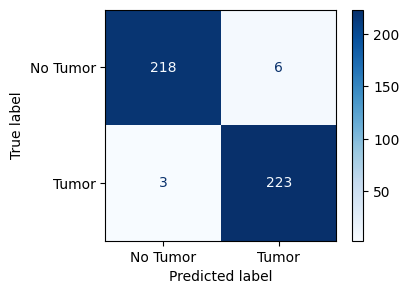

In [77]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm, 
    display_labels = ['No Tumor', 'Tumor']
)
plt.rcParams["figure.figsize"] = (4,3)
disp.plot(cmap='Blues')
plt.show()

## Reporte de clasificación

In [78]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       224
           1       0.97      0.99      0.98       226

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

